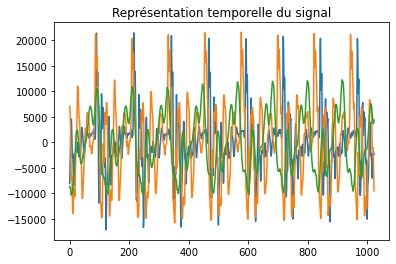

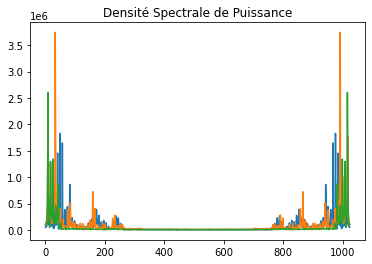

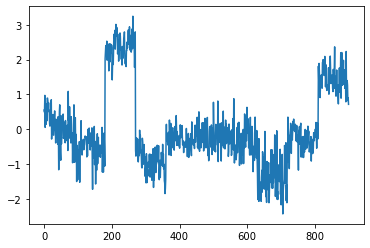

In [19]:
import os
import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy
import base
import TPClassif 

prefixe=['aa','ee','eh','eu','ii','oe','oh','oo','uu','yy']

baseApprentissage=[]
baseTest=[]
baseEntiere=[]

listVecteurCoefficientsApprentissage=[]

vecteurClasseApprentissage=[]

"""
Remplissage de la base complete contenant tous les individus disponibles
"""
#iteration sur l'ensemble des fichiers .wav du dossier Signaux
for nomFichier in os.listdir('Signaux'):
    #Remplissage de la base entiere, avec le noms des fichier
    baseEntiere.append(nomFichier)

"""
Affichage de 3 signaux
"""
#on recupere fe et les echantillons dans le .wav de 3 signaux pour les comparer en les affichant
(fe,echantillons)=scipy.io.wavfile.read('Signaux/'+baseEntiere[5])
(fe2,echantillons2)=scipy.io.wavfile.read('Signaux/'+baseEntiere[500])
(fe3,echantillons3)=scipy.io.wavfile.read('Signaux/'+baseEntiere[800])
#affichage
plt.figure(1) 
plt.plot(echantillons) 
plt.plot(echantillons2)
plt.plot(echantillons3)
plt.title('Représentation temporelle du signal')
#transformee de Fourier rapide
dsp=numpy.abs(numpy.fft.fft(echantillons)) 
dsp2=numpy.abs(numpy.fft.fft(echantillons2)) 
dsp3=numpy.abs(numpy.fft.fft(echantillons3)) 
plt.figure(2) 
plt.plot(dsp)
plt.plot(dsp2)
plt.plot(dsp3)
plt.title('Densité Spectrale de Puissance')
plt.show()

"""
remplissage de la base d'apprentissage
"""
#on retire 10 fichiers par type de son de la base pour que la base d'apprentissage
#comprennent 90% des individus (les 10 derniers)
baseEntiere.sort()
for i in baseEntiere:
    if('90'in i or '91'in i or '92'in i or '93'in i or '94'in i or '95'in i or '96'in i or '97'in i or '98'in i or '99'in i):
        baseTest.append(i)
    else:
        baseApprentissage.append(i) 
        
#on itere sur la baseApprentissage pour en déduire la matricedes mfcc
for i in baseApprentissage:
    #, leur fe et les echantillons dans le .wav
    (fe,echantillons)=scipy.io.wavfile.read('Signaux/'+i)
    
    #vecteur 900x1 qui affecte un numero de classe a chaque fichier (pour aller de 1 à 10, +1)
    numeroClasse=prefixe.index(i[0:2])+1
    vecteurClasseApprentissage.append(numeroClasse)
    
    #calcul des coefficients mfcc
    vecteurCoefficients=base.mfcc(echantillons, fe, len(echantillons)/fe,len(echantillons)/fe)    
    listVecteurCoefficientsApprentissage.append(vecteurCoefficients[0])

#on convertit la liste "vecteurClasseApprentissage" en array car TPClassif utilise des array
arrayVecteurClasseApprentissage=numpy.array(vecteurClasseApprentissage)

#creation de la matrice des MFCC pour la base d'apprentissage
matrixVecteursCoeffApprentissage = numpy.array(listVecteurCoefficientsApprentissage)

"""
implementation de l'AFD
"""
#calcul centres des gravite
centreGravites=TPClassif.CalculerCentresGravite(matrixVecteursCoeffApprentissage,arrayVecteurClasseApprentissage)
#print(centreGravites)

#centre et reduit les individus
individusCentresReduits=TPClassif.CalculerIndividusCentresReduits(matrixVecteursCoeffApprentissage,centreGravites)
#print(individusCentresReduits)

centreGravites=TPClassif.CalculerCentresGravite(individusCentresReduits,arrayVecteurClasseApprentissage)
#print(centreGravites)

#calcul des variances, totale, intra et interclasse
[vt,va,ve]=TPClassif.CalculerVariances(individusCentresReduits,arrayVecteurClasseApprentissage,centreGravites)
#print(variances)

#calcul matrices de covariance totale, intra et interclasse
[ct,ca,ce]=TPClassif.CalculerMatricesCovariance(individusCentresReduits,arrayVecteurClasseApprentissage,centreGravites)
#print(matricesDeCovariance)

#maximisation du nouveau critere
CAinv=numpy.linalg.inv(ca)
CAinvCE=CAinv*ce
valp, vecp = numpy.linalg.eig(CAinvCE)
#print(valp,vecp)

#projection sur les nvx axes
#trouver le bon ordre et la bonne transposee
individusApresAFD=numpy.dot(vecp,individusCentresReduits.transpose())
